In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Dataset

### Import the dataset

In [2]:
reviews = pd.read_csv("Womens Clothing E-Commerce Reviews.csv")
reviews.head()

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


### Check missing values

In [3]:
reviews.drop(columns=reviews.columns[0], axis=1, inplace=True)
print(f"Shape of the data is (row, column): {reviews.shape}")
print(f"Information about the dataset: {reviews.info()}")

Shape of the data is (row, column): (23486, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23486 entries, 0 to 23485
Data columns (total 10 columns):
Clothing ID                23486 non-null int64
Age                        23486 non-null int64
Title                      19676 non-null object
Review Text                22641 non-null object
Rating                     23486 non-null int64
Recommended IND            23486 non-null int64
Positive Feedback Count    23486 non-null int64
Division Name              23472 non-null object
Department Name            23472 non-null object
Class Name                 23472 non-null object
dtypes: int64(5), object(5)
memory usage: 1.8+ MB
Information about the dataset: None


In [4]:
print(f"Missing values in the dataset: {reviews.isnull().sum()}")

Missing values in the dataset: Clothing ID                   0
Age                           0
Title                      3810
Review Text                 845
Rating                        0
Recommended IND               0
Positive Feedback Count       0
Division Name                14
Department Name              14
Class Name                   14
dtype: int64


Quite some missing values for Title and Review Text. We can just fill na as '' when preprocessing them. For Division Name, Depart Name, Class Name, we can fill na with 'Unknown' later.

### Some stats
Some basic stats can be found here https://www.kaggle.com/datasets/nicapotato/womens-ecommerce-clothing-reviews

In [5]:
df = reviews

#### Recommendation vs Rating

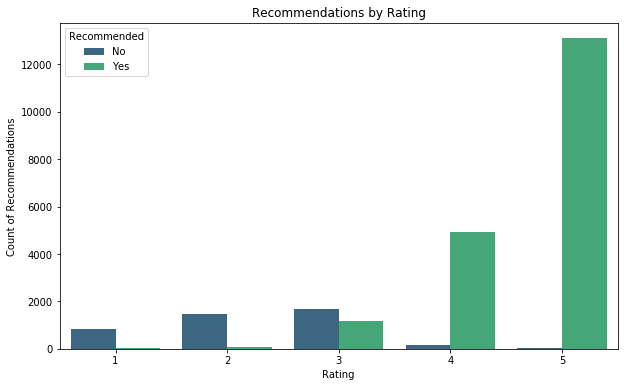

In [6]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Rating', hue='Recommended IND', data=df, palette='viridis')

plt.title('Recommendations by Rating')
plt.xlabel('Rating')
plt.ylabel('Count of Recommendations')

# Adding a legend
plt.legend(title='Recommended', loc='upper left', labels=['No', 'Yes'])

plt.show()

#### Positive feedback vs Rating

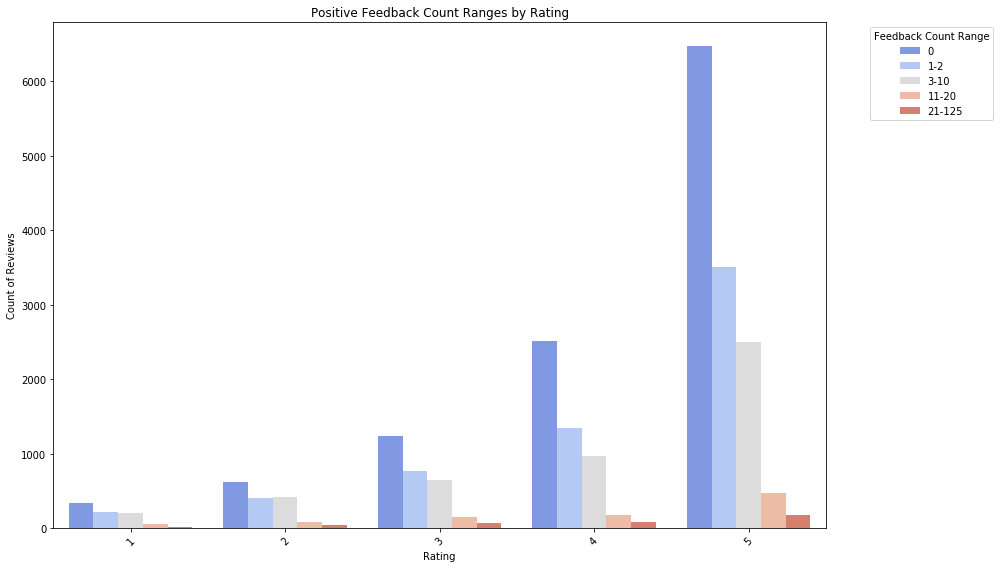

In [7]:
feedback_bins = [-1, 0, 2, 10, 20, 125]
feedback_labels = ['0', '1-2', '3-10', '11-20', '21-125']

# Create a new column 'Feedback Range' in the DataFrame
df['Feedback Range'] = pd.cut(df['Positive Feedback Count'], bins=feedback_bins, labels=feedback_labels)

# Prepare the order of feedback ranges based on the buckets defined
feedback_order = feedback_labels

# Create a larger figure size to handle the multiple categories
plt.figure(figsize=(14, 8))

# Count plot for each rating and feedback range
sns.countplot(data=df, x='Rating', hue='Feedback Range', hue_order=feedback_order, palette='coolwarm')

plt.title('Positive Feedback Count Ranges by Rating')
plt.xlabel('Rating')
plt.ylabel('Count of Reviews')

# Rotate the x-axis labels for better readability if necessary
plt.xticks(rotation=45)

# Move the legend out of the plot
plt.legend(title='Feedback Count Range', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()  # Adjust layout to fit the legend and axis labels
plt.show()

#### Age vs Rating

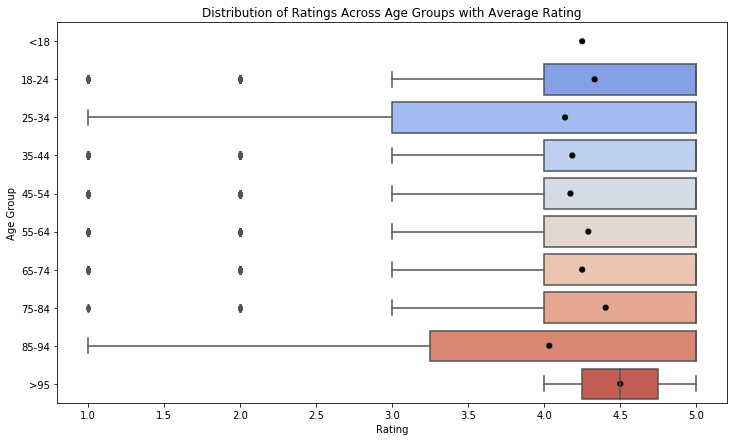

In [8]:
# Define bins for the age range
bins = [0, 18, 25, 35, 45, 55, 65, 75, 85, 95, 105]
labels = ['<18', '18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75-84', '85-94', '>95']
df['Age Group'] = pd.cut(df['Age'], bins=bins, labels=labels, right=False)

# Calculate the average rating for each age group
avg_rating_per_age_group = df.groupby('Age Group')['Rating'].mean().reindex(labels)

# Check for NaN values in the average ratings and fill them if needed
avg_rating_per_age_group = avg_rating_per_age_group.fillna(value=avg_rating_per_age_group.median())

# Boxplot with age groups
plt.figure(figsize=(12, 7))
sns.boxplot(x='Rating', y='Age Group', data=df, palette="coolwarm", order=labels)

# Overlay the average rating
sns.pointplot(x=avg_rating_per_age_group.values, y=avg_rating_per_age_group.index, color='black', join=False, scale=0.7, orient='h')

plt.title('Distribution of Ratings Across Age Groups with Average Rating')
plt.xlabel('Rating')
plt.ylabel('Age Group')
plt.show()

## Preprocessing

lowercasing, removing stopwords, punctuation, numbers, and lemmatization, fill in missing categorical values

In [11]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import string
import re

In [12]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lswht\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lswht\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\lswht\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [13]:
# Function to preprocess the text
def preprocess_text(text):
    # Lowercasing
    text = text.lower()
    
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # text = re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A)
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    
    # Tokenization
    tokens = word_tokenize(text)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    # Re-create text from tokens
    text = ' '.join(tokens)
    return text

df['Review Text'] = df['Review Text'].fillna('').apply(preprocess_text)
df['Title'] = df['Title'].fillna('').apply(preprocess_text)

# Fill missing categorical variables with 'Unknown'
categorical_cols = ['Division Name', 'Department Name', 'Class Name']
df[categorical_cols] = df[categorical_cols].fillna('Unknown')

df.head()
# df.to_csv("Processed_reviews.csv")

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,Feedback Range,Age Group
0,767,33,,absolutely wonderful silky sexy comfortable,4,1,0,Initmates,Intimate,Intimates,0,25-34
1,1080,34,,love dress sooo pretty happened find store im ...,5,1,4,General,Dresses,Dresses,3-10,25-34
2,1077,60,major design flaw,high hope dress really wanted work initially o...,3,0,0,General,Dresses,Dresses,0,55-64
3,1049,50,favorite buy,love love love jumpsuit fun flirty fabulous ev...,5,1,0,General Petite,Bottoms,Pants,0,45-54
4,847,47,flattering shirt,shirt flattering due adjustable front tie perf...,5,1,6,General,Tops,Blouses,3-10,45-54
